Model 2 : RandomForest
- Lags
- date features
- material information
- transport information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [2]:
Positive_Deliveries = True #Set 0 for negative deliveries
weekend0 = True #Set 0 for positive deliveries during the weekend
Remove_RareOccurences=True
Remove_Outliers=False
AdaptativeFirstDate=False
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")

In [3]:
def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("./data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("./submissions/" + filename, index=False)
    print(submission.head())


def RemoveOutliers(df,column):
        # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
        # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

        # Filter the DataFrame to exclude outliers
    df = df[
        (df[column] >= lower_bound) &
        (df[column] <= upper_bound)
    ]
    return df



In [4]:
# ---------------------------
# Config: lags & rollings
# ---------------------------
SHORT_LAGS      = []#[1,2,3,4,5,6,7,8,9,10]
WEEKDAY_LAGS    = [7,14,21,28,35,42,49,56]
YEARLY_LAGS     = [360,361,362,363,364,365,366,367,368,369,370]
ALL_LAGS        = sorted(set(SHORT_LAGS + WEEKDAY_LAGS + YEARLY_LAGS))
ROLL_WINDOWS    = [7, 14, 30] # Of last year



def create_lag_features(data,removeNA=True):
    target="net_weight"
    d = data.copy()

    for lag in ALL_LAGS:
        d[f"lag_{lag}"] = d[target].shift(lag)

    # --- rolling aggregates (captures trend / momentum) ---
    for window in ROLL_WINDOWS:
        d[f"roll_mean_{window}"] = d[target].shift(365).rolling(window).mean()
        d[f"roll_std_{window}"] = d[target].shift(365).rolling(window).std()

    # drop first rows with missing lags
    if removeNA:
        d = d.dropna().reset_index(drop=True)

    return d

def create_calendar_features(df,datecol='date'):
    df[f"{datecol}_year"] = df[datecol].dt.year-2004
    df[f"{datecol}_month"] = df[datecol].dt.month
    df[f"{datecol}_week"] = df[datecol].dt.isocalendar().week
    df[f"{datecol}_dayofmonth"] = df[datecol].dt.day 
    df[f"{datecol}_dayofweek"] = df[datecol].dt.dayofweek
    df[f"{datecol}_dayofyear"] = df[datecol].dt.dayofyear
    df[f"{datecol}_isweekend"] = df[datecol].dt.dayofweek.isin([5,6])
    return df



In [ ]:
receivals = pd.read_csv('./data/kernel/receivals.csv')

receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily_receivals = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)

if Remove_RareOccurences:
    stats = (
        daily_receivals.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

    rare_rm_id = stats.index[(stats["last_delivery"] <= cutoff) | (stats["total_deliveries"] <= 3)]

    print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
    # I remove rare_rm_id 
    daily_receivals = daily_receivals[~daily_receivals["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

if Remove_Outliers:
    daily_receivals=RemoveOutliers(daily_receivals,"net_weight")

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])

daily_receivals = (
    daily_receivals.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

if AdaptativeFirstDate:
    # first actual delivery per rm_id
    first_delivery = (
        daily_receivals
        .loc[daily_receivals["net_weight"] > 0]
        .groupby("rm_id", as_index=False)
        .agg(first_date=("date", "min"))
    )
    
    first_delivery["first_date"] = pd.to_datetime(first_delivery["first_date"])

    start_1st = first_delivery["first_date"] - pd.DateOffset(years=1, months=1)
    start_3y  = forecast_start - pd.DateOffset(years=3,months=1)

    # pick the earlier of the two (vectorized, pandas-safe)
    first_delivery["start_date"] = start_1st.where(start_1st <= start_3y, start_3y)

    daily_receivals = (
    daily_receivals
    .merge(first_delivery[["rm_id", "start_date"]], on="rm_id", how="inner")
    .loc[lambda d: d["date"] >= d["start_date"]]
    .drop(columns="start_date")
    .sort_values(["rm_id", "date"])
    .reset_index(drop=True)
)

daily_receivals=create_lag_features(daily_receivals)
daily_receivals=create_calendar_features(daily_receivals,datecol='date')
daily_receivals = daily_receivals.sort_values(["rm_id","date"]).reset_index(drop=True)
print(daily_receivals.columns)
print(len(daily_receivals))
hist = daily_receivals[daily_receivals['rm_id'] == 2130.0]
print(hist)

We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,
       ...
       4101.0, 4161.0, 4343.0, 4381.0, 4401.0, 4461.0, 4462.0, 4463.0, 4481.0,
       4501.0],
      dtype='float64', name='rm_id', length=133)
Index(['rm_id', 'date', 'net_weight', 'lag_7', 'lag_14', 'lag_21', 'lag_28',
       'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_360', 'lag_361', 'lag_362',
       'lag_363', 'lag_364', 'lag_365', 'lag_366', 'lag_367', 'lag_368',
       'lag_369', 'lag_370', 'roll_mean_7', 'roll_std_7', 'roll_mean_14',
       'roll_std_14', 'roll_mean_30', 'roll_std_30', 'date_year', 'date_month',
       'date_week', 'date_dayofmonth', 'date_dayofweek', 'date_dayofyear',
       'date_isweekend'],
      dtype='object')
536576
Empty DataFrame
Columns: [rm_id, date, net_weight, lag_7, lag_14, lag_21, lag_28, lag_35, lag_42, lag_49, lag_56, lag_360, lag_361, lag_362, lag_363, lag_364, lag_365, la

In [80]:
def flag_any(x, patterns):
    if not isinstance(x, str):
        return 0
    x = x.lower()
    return int(any(p in x for p in patterns))

In [81]:
materials = pd.read_csv('./data/extended/materials.csv')
# I don't manage the deleted localisation -> next feature ?
print(len(materials))
print(materials.columns)
materials = materials.dropna(subset=["rm_id"])

materials["fam_6xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["6060","6063","6082","6005","6016"]))
materials["fam_5xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["5000","5754"]))
materials["fam_1xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["1050","1100"]))
materials["fam_pure"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["99.5","99,5","99.7","99,7","cspa","pm al","granalla","coil"]))
materials["fam_scrap_shred"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["shredd","tritura","scrap"]))
materials["fam_briquetas"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["briquet","compact"]))
materials["fam_mele"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["melé","cacharro"]))
materials["fam_master"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, [" si "," mg "," mn "," cu "," cr "," fe ","ti-bors","wire","cable"]))
materials["treat_lacado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["lac","paint"]))
materials["treat_anodizado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["anod"]))
materials["treat_thermal_break"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["thermal break","puente t"]))

materials["loc_SB"] = materials["stock_location"].map(lambda x: flag_any(x, ["sb"]))
materials["loc_SA"] = materials["stock_location"].map(lambda x: flag_any(x, ["sa"]))
materials["loc_SC"] = materials["stock_location"].map(lambda x: flag_any(x, ["sc"]))
materials["loc_AA"] = materials["stock_location"].map(lambda x: flag_any(x, ["aa"]))
materials["loc_PM"] = materials["stock_location"].map(lambda x: flag_any(x, ["pm "]))

materials["loc_ThermalBreak"] = materials["stock_location"].map(lambda x: flag_any(x, ["thermal break","puente t"," pt"]))
materials["loc_Lavadero"] = materials["stock_location"].map(lambda x: flag_any(x, ["lavadero"]))
materials["loc_Granalla"] = materials["stock_location"].map(lambda x: flag_any(x, ["granalla"]))
materials["loc_Briquetas"] = materials["stock_location"].map(lambda x: flag_any(x, ["briquet"]))


# your flag columns already created above (fam_*, treat_*, loc_*)
flag_cols = [c for c in materials.columns if c.startswith(("fam_", "treat_", "loc_"))]

# Group and aggregate:
# - flags: max (so any 1 across the rm_id becomes 1)
# - format type: mean
# - keep a representative text for context (first)

materials_by_rm = (
    materials
    .groupby("rm_id", as_index=False)
    .agg({**{c: "mean" for c in flag_cols},
            "raw_material_format_type": "mean"})
)

# (optional) if you prefer ints for flags (0/1), cast them:
for c in flag_cols:
    materials_by_rm[c] = materials_by_rm[c].astype(int)

print(materials_by_rm[materials_by_rm["rm_id"]==2129])

1218
Index(['rm_id', 'product_id', 'product_version', 'raw_material_alloy',
       'raw_material_format_type', 'stock_location'],
      dtype='object')
     rm_id  fam_6xxx  fam_5xxx  fam_1xxx  fam_pure  fam_scrap_shred  \
74  2129.0         0         0         0         0                0   

    fam_briquetas  fam_mele  fam_master  treat_lacado  ...  loc_SB  loc_SA  \
74              0         0           0             0  ...       1       0   

    loc_SC  loc_AA  loc_PM  loc_ThermalBreak  loc_Lavadero  loc_Granalla  \
74       0       0       0                 0             0             0   

    loc_Briquetas  raw_material_format_type  
74              0                      33.0  

[1 rows x 22 columns]


In [82]:
transportation = pd.read_csv('./data/extended/transportation.csv')

transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])

#df_nan = transportation[transportation["purchase_order_id"].isna()] # no more nan values
#print(df_nan) #now empty
weight_cols = ["vehicle_start_weight","vehicle_end_weight",
               "gross_weight","tare_weight","net_weight"]
for c in weight_cols:
    transportation[c] = pd.to_numeric(transportation[c], errors="coerce")

# --- One-hot encode transporter_name -> 0/1 columns
transp_dum = pd.get_dummies(
    transportation["transporter_name"],
    prefix="_",
    dummy_na=False  # set True if you want a "transp_nan" column for missing
)

# attach dummies
transportation = pd.concat([transportation, transp_dum], axis=1)

# --- Build aggregation dict:
#     - transporter dummies: mean (→ proportion of trips with that transporter per rm_id)
#     - weights: mean
agg_dict = {**{c: "mean" for c in transp_dum.columns},
            **{c: "mean" for c in weight_cols}}

transportation_by_rm = (
    transportation
    .groupby("rm_id", as_index=False)
    .agg(agg_dict)
)

# pretty rounding for proportions/means
transportation_by_rm[transp_dum.columns] = transportation_by_rm[transp_dum.columns].round(3)
transportation_by_rm[weight_cols] = transportation_by_rm[weight_cols].round(3)
transportation_by_rm=transportation_by_rm.rename(columns={'net_weight': 'transp_mean_weight'})
print(transportation_by_rm.columns)

Index(['rm_id', '__Transporter0', '__Transporter1', '__Transporter10',
       '__Transporter11', '__Transporter12', '__Transporter13',
       '__Transporter14', '__Transporter15', '__Transporter16',
       '__Transporter17', '__Transporter18', '__Transporter19',
       '__Transporter2', '__Transporter20', '__Transporter21',
       '__Transporter22', '__Transporter23', '__Transporter24',
       '__Transporter3', '__Transporter4', '__Transporter5', '__Transporter6',
       '__Transporter7', '__Transporter8', '__Transporter9',
       'vehicle_start_weight', 'vehicle_end_weight', 'gross_weight',
       'tare_weight', 'transp_mean_weight'],
      dtype='object')


In [83]:
df_all = (
    daily_receivals
    .merge(materials_by_rm, on="rm_id", how="left")
    .merge(transportation_by_rm, on="rm_id", how="left")
)
df_all = df_all.sort_values(["rm_id","date"]).reset_index(drop=True)
print(df_all.columns)
print(len(df_all.columns))


Index(['rm_id', 'date', 'net_weight', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_14',
       'lag_21', 'lag_28', 'lag_35', 'lag_42', 'lag_49', 'lag_56', 'lag_360',
       'lag_361', 'lag_362', 'lag_363', 'lag_364', 'lag_365', 'lag_366',
       'lag_367', 'lag_368', 'lag_369', 'lag_370', 'roll_mean_7', 'roll_std_7',
       'roll_mean_14', 'roll_std_14', 'roll_mean_30', 'roll_std_30',
       'date_year', 'date_month', 'date_week', 'date_dayofmonth',
       'date_dayofweek', 'date_dayofyear', 'date_isweekend', 'fam_6xxx',
       'fam_5xxx', 'fam_1xxx', 'fam_pure', 'fam_scrap_shred', 'fam_briquetas',
       'fam_mele', 'fam_master', 'treat_lacado', 'treat_anodizado',
       'treat_thermal_break', 'loc_SB', 'loc_SA', 'loc_SC', 'loc_AA', 'loc_PM',
       'loc_ThermalBreak', 'loc_Lavadero', 'loc_Granalla', 'loc_Briquetas',
       'raw_material_format_type', '__Transporter0', '__Transporter1',
       '__Transporter10', '__Transporter1

In [84]:
columns_output = ['net_weight']
columns_input = [c for c in df_all.columns if c not in ["rm_id","date","net_weight"]]

X = df_all[columns_input]
#X = pd.get_dummies(X, columns=['rm_id'], drop_first=True)
y = df_all[columns_output].values.ravel() # cast (n,1) to (n,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=False)
# Initialize the model
model = RandomForestRegressor(n_estimators=600,      # number of trees
                                max_depth=None,        # let trees grow fully (fine for big data)
                                min_samples_leaf=2,    # reduces overfitting a bit
                                max_features="sqrt",   # each split tests only ~√(n_features) features (good general setting) 
                                n_jobs=-1, 
                               random_state=42)
#n_jobs=-1 to use all cores
# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE) for each target
mae_net_weight = mean_absolute_error(y_test, y_pred)
# Calculate R-squared (R²) for each target
r2_net_weight = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error for Net Weight: {mae_net_weight:.2f}")
print(f"R-squared for Net Weight: {r2_net_weight:.2f}")


Mean Absolute Error for Net Weight: 857.31
R-squared for Net Weight: 0.23


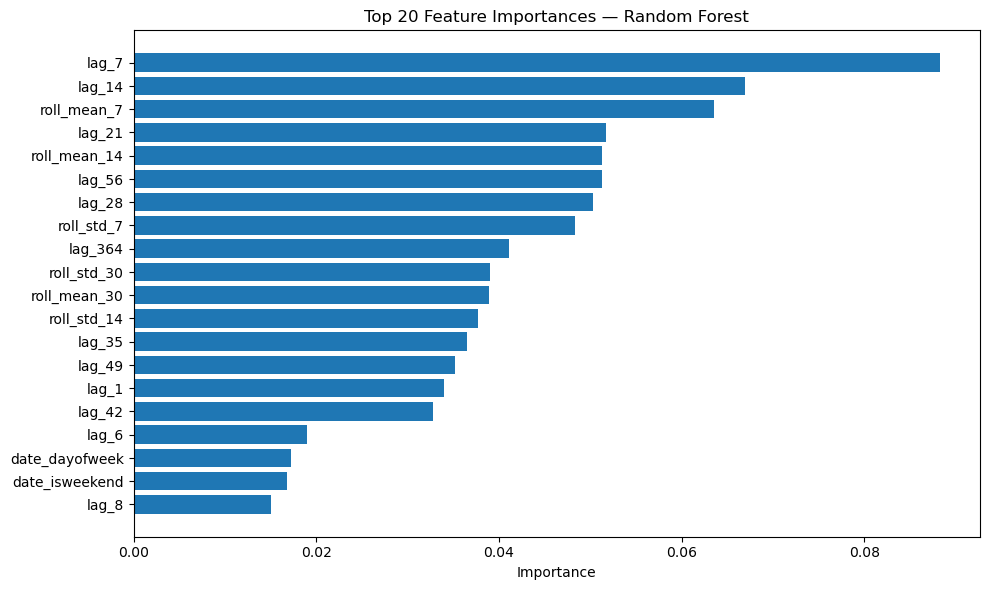

<BarContainer object of 92 artists>

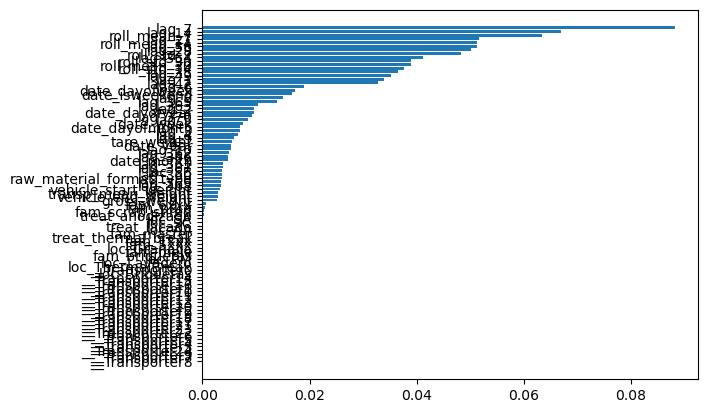

In [85]:
# get importances
feat_imp = pd.DataFrame({
    "feature": columns_input,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

# plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][:20][::-1], feat_imp["importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])

In [86]:
data_for_forecast = df_all[df_all["date"]>=pd.Timestamp("2023-12-01")].copy()
forecast_range = pd.date_range(forecast_start, forecast_end, freq="D", name="date")

rm_ids = pd.Index(data_for_forecast["rm_id"].unique(), name="rm_id")
columns=data_for_forecast.columns
static_cols = [c for c in data_for_forecast.columns
                    if c not in {"date","net_weight"} and not c.startswith(("lag_","roll_","date_"))]

multi_index = pd.MultiIndex.from_product(
    [rm_ids, forecast_range],
    names=["rm_id", "date"]
)
# Create the base DataFrame
forecast_base_df = pd.DataFrame(index=multi_index).reset_index()
forecast_base_df=create_calendar_features(forecast_base_df,'date')
static_map = (
    data_for_forecast
      .drop_duplicates(subset=["rm_id"], keep="first")[[*static_cols]]
)
# attach to the base grid
forecast_base_df = forecast_base_df.merge(static_map, on="rm_id", how="left")

for day in forecast_range:
    day_df = forecast_base_df[forecast_base_df['date']==day]
    data_for_forecast = pd.concat([data_for_forecast, day_df])
    data_for_forecast=data_for_forecast.sort_values(["rm_id","date"]).reset_index(drop=True)

    data_for_forecast= create_lag_features(data_for_forecast,removeNA=False)

    input_rows = data_for_forecast.loc[
    data_for_forecast['date'] == day,
    columns_input
    ]

    preds = model.predict(input_rows)[0]

    # Get the index of the row(s) used for prediction
    idx = data_for_forecast[data_for_forecast['date'] == day].index

    # Assign the prediction to the correct row in data_forecast
    data_for_forecast.loc[idx, columns_output] = preds

df_pred_2025 = data_for_forecast[data_for_forecast['date'] >= forecast_start]


In [87]:
df_pred_2025 = data_for_forecast[data_for_forecast['date'] >= forecast_start]

In [96]:
def plot_history_vs_forecast(df_all, df_pred_2025, rm_id):
    # ensure types
    hist = df_all.loc[df_all["rm_id"] == rm_id, ["date", "net_weight"]].copy()
    pred = df_pred_2025.loc[df_pred_2025["rm_id"] == rm_id, ["date", "net_weight"]].copy()

    # plot
    plt.figure(figsize=(10, 5)) 
    plt.plot(hist["date"], hist["net_weight"], label="History")
    plt.plot(pred["date"], pred["net_weight"], label="Forecast")

    # reference line for forecast start (optional)
    fs = pd.Timestamp("2025-01-01")
    plt.axvline(fs, linestyle="--")

    plt.title(f"rm_id {rm_id} — net_weight: history vs forecast")
    plt.xlabel("Date")
    plt.ylabel("net_weight")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

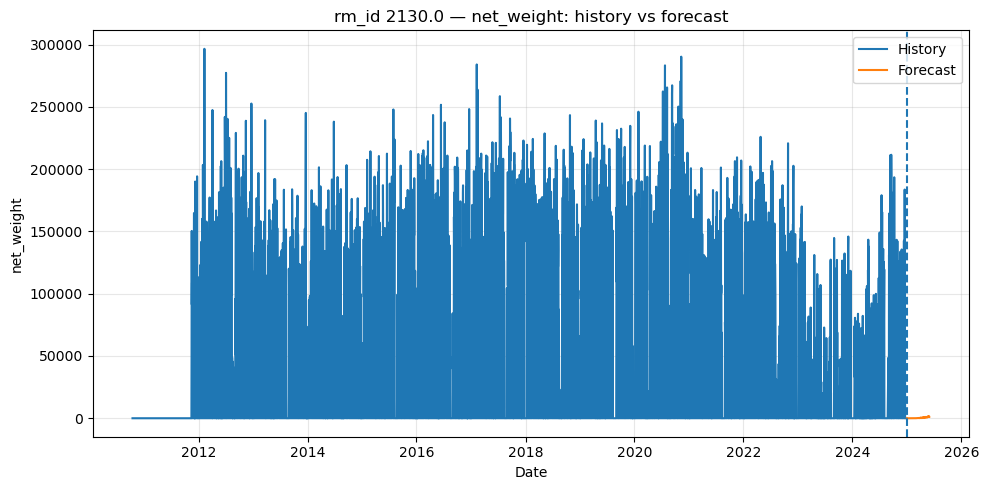

In [97]:
plot_history_vs_forecast(df_all, df_pred_2025, 2130.0)

In [90]:
#Fichier des predictions
df_final_cum  = (
    df_pred_2025.groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)


C:\Users\julie\AppData\Local\Temp\ipykernel_11024\545301989.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))


In [91]:
print_submission(df_final_cum,filename="RandomForest_ALL.csv")

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0
